In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import s3fs
from shapely.geometry import Point, Polygon
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import contextily as ctx

#from qaqc_utils import *

%matplotlib inline

In [2]:
# Helper function for plotting
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

# Shapefile of CA counties, for subsetting for a specific area
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp" )

## Pull all cleaned stations in Historical Data Platform Bucket
* includes lat & lon

In [3]:
# Read in all stations
df_all = pd.read_csv("s3://wecc-historical-wx/2_clean_wx/temp_clean_all_station_list.csv")

# Subset for cleaned stations (Y flag)
df_clean = df_all.loc[df_all['cleaned'] == 'Y']
df_clean.head(5)

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,cleaned,time_cleaned,network,...,pr_nobs,pr_5min_nobs,pr_1h_nobs,pr_24h_nobs,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs
0,0,ASOSAWOS_72681024131,43.567,-116.241,860.4504,1931-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-06 23:44:42+00:00,ASOSAWOS,...,400786.0,0.0,0.0,0.0,0.0,0.0,444433.0,379116.0,87216.0,470754.0
1,1,ASOSAWOS_72774024135,45.964,-112.501,1677.9240,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:34:21+00:00,ASOSAWOS,...,131484.0,0.0,0.0,0.0,0.0,0.0,177652.0,121517.0,0.0,183432.0
2,2,ASOSAWOS_72571094025,40.481,-107.218,2011.6800,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:44:41+00:00,ASOSAWOS,...,63539.0,0.0,0.0,0.0,0.0,0.0,371625.0,324697.0,0.0,374482.0
3,3,ASOSAWOS_72687600387,44.400,-118.967,1127.1504,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:48:37+00:00,ASOSAWOS,...,14009.0,0.0,0.0,0.0,0.0,0.0,402892.0,320886.0,0.0,408311.0
4,4,ASOSAWOS_72020200118,45.417,-123.817,11.2776,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:46:35+00:00,ASOSAWOS,...,53279.0,0.0,0.0,0.0,0.0,0.0,397127.0,220449.0,0.0,401832.0


#### Subset for Valley Water Stations

In [4]:
# Set up a map
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
pr_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column

In [5]:
valley_water_stations = pr_stns[pr_stns['network']=='VALLEYWATER']
print(len(valley_water_stations))

49


#### Quick Map of All Valley Water Stations

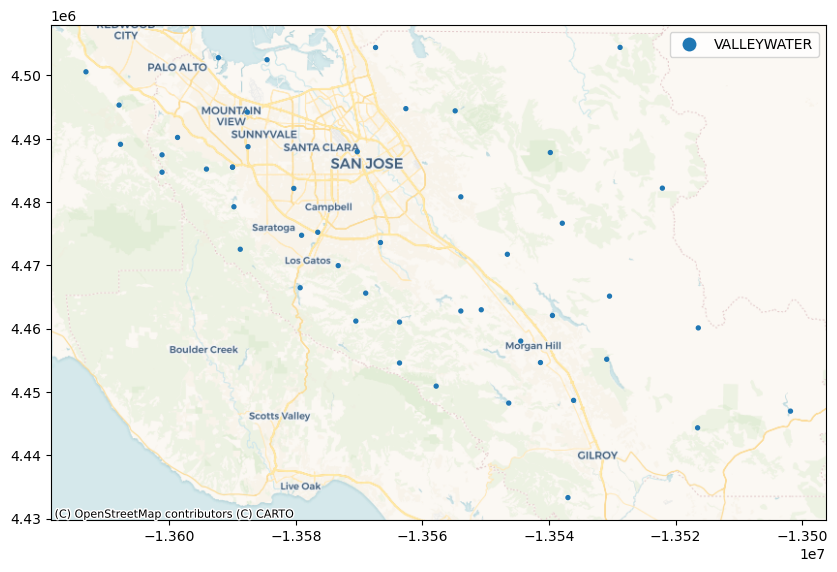

In [6]:
# Mapping
ax = valley_water_stations.plot(column='network', markersize=8, legend=True, figsize=(10,10))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Also, can use your geodataframe and .explore() to zoom around
## pr_stns.explore()

## Pull all Valley Water QA/QC'd data

In [7]:
# Authenticate using AWS credentials
s3 = s3fs.S3FileSystem(anon=False)

# Define the correct parent S3 directory
parent_s3_path = "wecc-historical-wx/4_merge_wx/VALLEYWATER/"

# List available Zarr folders (fixing the duplicated path issue)
zarr_folders = [f"s3://{path}" for path in s3.ls(parent_s3_path) if path.endswith(".zarr")]

print("Found Zarr datasets:", zarr_folders)

# Read each Zarr dataset
datasets = {}

for zarr_path in zarr_folders:
    try:
        ds = xr.open_zarr(zarr_path, storage_options={"s3": {"anon": False}})
        datasets[zarr_path] = ds
        print(f"Loaded: {zarr_path}")
    except Exception as e:
        print(f"Error loading {zarr_path}: {e}")


Found Zarr datasets: ['s3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6001.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6004.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6008.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6015.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6016.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6017.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6018.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6021.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6023.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6034.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6036.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6041.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6044.zarr', 's3://wecc-historical-wx/4_merge_wx/VALLEY

### Use the subsetted Valley Water Station coordinates to append to the station data

In [9]:
valley_water_stations = valley_water_stations.rename(columns={'era-id': 'station'})

# Define the function to merge geometry with dataset
def merge_with_geometry(ds, valley_water_stations):
    """Converts an xarray dataset to a DataFrame and merges with station geometries."""
    df = ds.to_dataframe().reset_index()  # Convert dataset to DataFrame
    
    if 'station' not in df.columns:
        print("Warning: No 'station' column in dataset. Check your dataset structure!")
        return None

    # Merge with valley_water_stations to add geometry
    merged_df = df.merge(valley_water_stations[['station', 'geometry']], on='station', how='left')

    return merged_df

# Now load the Zarr datasets and add geometry to them
merged_datasets = {}
for zarr_path, ds in datasets.items():
    # Merge geometry with each dataset
    merged_df = merge_with_geometry(ds, valley_water_stations)
    
    if merged_df is not None:
        merged_datasets[zarr_path] = merged_df  # Store the merged dataset


#### View each station's variables

In [22]:
'''
for zarr_path, ds in datasets.items():
    print(f"Variables in {zarr_path}:")
    print(list(ds.data_vars))  # List of data variables (columns)
    print("\nMetadata:")
    print(ds.attrs)  # Prints dataset-level metadata
    print("\n" + "="*50 + "\n")  # Separator for readability
'''

'\nfor zarr_path, ds in datasets.items():\n    print(f"Variables in {zarr_path}:")\n    print(list(ds.data_vars))  # List of data variables (columns)\n    print("\nMetadata:")\n    print(ds.attrs)  # Prints dataset-level metadata\n    print("\n" + "="*50 + "\n")  # Separator for readability\n'

In [ ]:
# View merged datasets
merged_datasets

{'s3://wecc-historical-wx/4_merge_wx/VALLEYWATER/VALLEYWATER_6001.zarr':                       time           station  anemometer_height_m  elevation  \
 0      1985-02-07 20:00:00  VALLEYWATER_6001                  NaN      58.73   
 1      1985-02-07 21:00:00  VALLEYWATER_6001                  NaN      58.73   
 2      1985-02-07 22:00:00  VALLEYWATER_6001                  NaN      58.73   
 3      1985-02-07 23:00:00  VALLEYWATER_6001                  NaN      58.73   
 4      1985-02-08 00:00:00  VALLEYWATER_6001                  NaN      58.73   
 ...                    ...               ...                  ...        ...   
 349943 2025-01-09 19:00:00  VALLEYWATER_6001                  NaN      58.73   
 349944 2025-01-09 20:00:00  VALLEYWATER_6001                  NaN      58.73   
 349945 2025-01-09 21:00:00  VALLEYWATER_6001                  NaN      58.73   
 349946 2025-01-09 22:00:00  VALLEYWATER_6001                  NaN      58.73   
 349947 2025-01-09 23:00:00  VALLEYWA

### Count non-nan precipitation for each station and map
* station volume of precip data indicated in relative plotted size

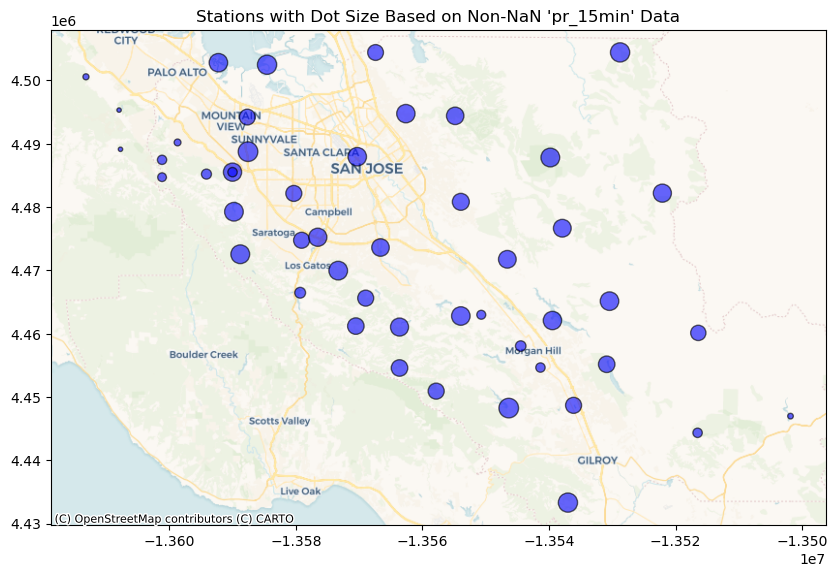

In [13]:
# Create a new DataFrame to store station data with non-NaN counts
station_data_list = []

for zarr_path, df in merged_datasets.items():
    # Count non-NaN values in 'pr_15min' for each station
    non_nan_counts = df.groupby('station')['pr_15min'].count().reset_index()
    non_nan_counts.rename(columns={'pr_15min': 'valid_pr_15min_count'}, inplace=True)

    # Merge with station geometries
    station_data = valley_water_stations[['station', 'geometry']].merge(non_nan_counts, on='station', how='left')

    station_data_list.append(station_data)

# Combine all station datasets
all_stations_df = pd.concat(station_data_list, ignore_index=True)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(all_stations_df, geometry='geometry', crs="EPSG:3857")

# Normalize size (optional) for better scaling
gdf['size'] = gdf['valid_pr_15min_count'] / gdf['valid_pr_15min_count'].max() * 200  # Adjust multiplier as needed

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, markersize=gdf['size'], alpha=0.6, color='blue', edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

plt.title("Stations with Dot Size Based on Non-NaN 'pr_15min' Data")
plt.show()


## Merge all stations precipitation data together, creating a single df
* each column represents a station and its standardized, 1 hour precipitation values for a given time point

In [14]:
# Create an empty list to store DataFrames from each station
station_dfs = []

num_stations = 50  # Process a subset first

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min' for this station
            station_data = ds.isel(station=i)[["pr_15min"]].to_dataframe()

            # Drop 'station' column if it exists
            if "station" in station_data.columns:
                station_data = station_data.drop(columns=["station"])

            # Rename columns to include the station ID
            station_data = station_data.rename(columns={
                "pr_15min": f"pr_1hr_{station_id}"
            })

            # Append to list
            station_dfs.append(station_data)

# Merge all station DataFrames on 'time'
merged_df = pd.concat(station_dfs, axis=1)

# Reset index to make 'time' a column
merged_df = merged_df.reset_index()

# Display result
print(len(merged_df))
print(merged_df.head(10))

443194
                 time  pr_1hr_VALLEYWATER_6001  pr_1hr_VALLEYWATER_6004  \
0 1974-06-21 08:00:00                      NaN                      NaN   
1 1974-06-21 09:00:00                      NaN                      NaN   
2 1974-06-21 10:00:00                      NaN                      NaN   
3 1974-06-21 11:00:00                      NaN                      NaN   
4 1974-06-21 12:00:00                      NaN                      NaN   
5 1974-06-21 13:00:00                      NaN                      NaN   
6 1974-06-21 14:00:00                      NaN                      NaN   
7 1974-06-21 15:00:00                      NaN                      NaN   
8 1974-06-21 16:00:00                      NaN                      NaN   
9 1974-06-21 17:00:00                      NaN                      NaN   

   pr_1hr_VALLEYWATER_6008  pr_1hr_VALLEYWATER_6015  pr_1hr_VALLEYWATER_6016  \
0                      NaN                      NaN                      NaN   
1      

## Now, view each stations max standardized (1 hour) precipitation values for their respective data range
* includes the corresponding QAQC code value (either nan, 31, or 32)
* includes the time point in whiche the max precipitation value occurred

In [ ]:
num_stations =50

# List to store max 'pr_15min' values per station
max_pr_rows = []

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min' and 'pr_15min_eraqc' for this station
            station_data = ds.isel(station=i)[["pr_15min", "pr_15min_eraqc"]].to_dataframe()

            # Drop 'station' column if it exists
            station_data = station_data.drop(columns=["station"], errors="ignore")

            # Rename columns to 'pr_1hr' equivalents
            station_data = station_data.rename(columns={"pr_15min": "pr_1hr", "pr_15min_eraqc": "pr_1hr_eraqc"})

            # Find the row with max precipitation
            max_idx = station_data["pr_1hr"].idxmax()  # This gives the index (likely a timestamp)

            if pd.notna(max_idx):  # Ensure max_idx is valid
                max_value = station_data.loc[max_idx, "pr_1hr"]
                max_time = max_idx  # The index is likely the timestamp

                # Get the corresponding 'pr_15min_eraqc' value at max time
                max_eraqc_value = station_data.loc[max_idx, "pr_1hr_eraqc"]

                # Append result as a dictionary
                max_pr_rows.append({
                    "station": station_id,
                    "pr_1hr_max": max_value,
                    "pr_1hr_eraqc": max_eraqc_value,  # Include eraqc value
                    "max_time": max_time,
                })

# Convert list to DataFrame
max_pr_df = pd.DataFrame(max_pr_rows)

# Display the final DataFrame with one row per station
print(max_pr_df)


             station  pr_1hr_max pr_1hr_eraqc            max_time
0   VALLEYWATER_6001   20.066000          nan 1996-05-16 08:00:00
1   VALLEYWATER_6004   65.000124          nan 2006-02-27 14:00:00
2   VALLEYWATER_6008  277.000000         32.0 2021-01-29 00:00:00
3   VALLEYWATER_6015   41.910000          nan 1977-12-19 08:00:00
4   VALLEYWATER_6016   80.010000          nan 1988-03-26 02:00:00
5   VALLEYWATER_6017  453.000000         32.0 2022-07-01 08:00:00
6   VALLEYWATER_6018   29.972000          nan 1996-01-25 08:00:00
7   VALLEYWATER_6021   46.999906          nan 2004-12-30 14:00:00
8   VALLEYWATER_6023   47.000000          nan 2020-03-20 19:00:00
9   VALLEYWATER_6034  195.072000         32.0 1988-03-26 07:00:00
10  VALLEYWATER_6036   23.000010          nan 2014-12-11 18:00:00
11  VALLEYWATER_6041   21.999981         32.0 2009-10-13 23:00:00
12  VALLEYWATER_6044   70.000114          nan 1996-11-07 19:00:00
13  VALLEYWATER_6048   70.000114          nan 1996-01-30 22:00:00
14  VALLEY

In [ ]:
# max_pr_df.to_csv('max_pr_df.csv')

### Lets see the volume of QAQC code flags per station
* counts number of 31 or 32 flags

In [ ]:
# Dictionary to store counts for each station
station_counts = []

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min_eraqc' for this station
            station_data = ds.isel(station=i)[["pr_15min_eraqc"]].to_dataframe()

            # Drop 'station' column if it exists
            station_data = station_data.drop(columns=["station"], errors="ignore")

            # Debugging: Print sample of the column
            print(f"Station: {station_id}")
            print(station_data["pr_15min_eraqc"].dropna().unique())  # Show unique non-null values

            # Ensure the values are properly casted to integers if necessary
            station_data["pr_15min_eraqc"] = station_data["pr_15min_eraqc"].astype("float").astype("Int64")

            # Count occurrences of 31 and 32
            count_31 = (station_data["pr_15min_eraqc"] == 31).sum()
            count_32 = (station_data["pr_15min_eraqc"] == 32).sum()

            # Store in list
            station_counts.append({
                "station": station_id,
                "count_31": count_31,
                "count_32": count_32,
            })

# Convert list to DataFrame
station_counts_df = pd.DataFrame(station_counts)

# Display the count DataFrame
print(station_counts_df)


Station: VALLEYWATER_6001
['nan']
Station: VALLEYWATER_6004
['nan']
Station: VALLEYWATER_6008
['nan' '32.0']
Station: VALLEYWATER_6015
['nan']
Station: VALLEYWATER_6016
['nan' '32.0']
Station: VALLEYWATER_6017
['nan' '32.0']
Station: VALLEYWATER_6018
['nan' '32.0']
Station: VALLEYWATER_6021
['nan' '32.0']
Station: VALLEYWATER_6023
['nan' '32.0']
Station: VALLEYWATER_6034
['nan' '32.0']
Station: VALLEYWATER_6036
['nan' '32.0']
Station: VALLEYWATER_6041
['nan' '32.0']
Station: VALLEYWATER_6044
['nan' '32.0']
Station: VALLEYWATER_6048
['nan' '32.0']
Station: VALLEYWATER_6053
['nan' '32.0']
Station: VALLEYWATER_6067
['nan' '32.0']
Station: VALLEYWATER_6069
['nan' '32.0']
Station: VALLEYWATER_6077
['nan' '32.0']
Station: VALLEYWATER_6079
['nan' '32.0']
Station: VALLEYWATER_6098
['nan' '32.0']
Station: VALLEYWATER_6099
['nan' '32.0']
Station: VALLEYWATER_6100
['nan' '32.0']
Station: VALLEYWATER_6102
['nan' '32.0']
Station: VALLEYWATER_6104
['nan' '32.0']
Station: VALLEYWATER_6108
['nan' '32.

In [ ]:
#station_counts_df.to_csv('station_qaqc_code_counts.csv')

### Quick summary statistics for each station, excluding 0 precipitation values as they bring the mean, median, and IQR ranges wayyyy down

In [18]:
# Replace zeros with NaN to ignore them in calculations
merged_df_no_zeros = merged_df.replace(0, np.nan)

# Compute descriptive statistics excluding zeros
print(merged_df_no_zeros.describe())


                                time  pr_1hr_VALLEYWATER_6001  \
count                         443194              7053.000000   
mean   1999-10-01 12:30:00.000000512                 2.015525   
min              1974-06-21 08:00:00                 0.762000   
25%              1987-02-09 22:15:00                 1.000001   
50%              1999-10-01 12:30:00                 1.016000   
75%              2012-05-22 02:45:00                 2.540000   
max              2025-01-10 17:00:00                20.066000   
std                              NaN                 1.651653   

       pr_1hr_VALLEYWATER_6004  pr_1hr_VALLEYWATER_6008  \
count             11951.000000              9073.000000   
mean                  2.758644                 2.016260   
min                   0.762000                 1.000000   
25%                   1.000001                 1.000001   
50%                   2.000001                 1.000001   
75%                   3.048000                 2.540000   
m

### Look at each stations temporal range
* returns the range & number of years

In [19]:
# List to store station date ranges
station_ranges = []

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract time dimension for this station
            time_values = ds["time"].values

            if len(time_values) > 0:  # Ensure there are time values
                min_time = pd.to_datetime(time_values.min())  # Earliest date
                max_time = pd.to_datetime(time_values.max())  # Latest date
                total_years = max_time.year - min_time.year + 1  # Inclusive year count

                # Append result as a dictionary
                station_ranges.append({
                    "station": station_id,
                    "date_range": f"{min_time.date()} to {max_time.date()}",
                    "total_years": total_years
                })

# Convert list to DataFrame
station_date_ranges_df = pd.DataFrame(station_ranges)

# Display final DataFrame
print(station_date_ranges_df)


             station                date_range  total_years
0   VALLEYWATER_6001  1985-02-07 to 2025-01-09           41
1   VALLEYWATER_6004  1982-04-04 to 2025-01-09           44
2   VALLEYWATER_6008  1975-10-17 to 2025-01-09           51
3   VALLEYWATER_6015  1976-11-17 to 2025-01-09           50
4   VALLEYWATER_6016  1975-01-24 to 2025-01-09           51
5   VALLEYWATER_6017  1980-02-19 to 2025-01-09           46
6   VALLEYWATER_6018  1994-07-01 to 2025-01-09           32
7   VALLEYWATER_6021  1989-07-01 to 2025-01-09           37
8   VALLEYWATER_6023  1992-07-01 to 2025-01-09           34
9   VALLEYWATER_6034  1983-12-14 to 2025-01-09           43
10  VALLEYWATER_6036  1979-04-25 to 2025-01-09           47
11  VALLEYWATER_6041  1981-01-28 to 2025-01-09           45
12  VALLEYWATER_6044  1989-07-01 to 2025-01-09           37
13  VALLEYWATER_6048  1974-11-09 to 2025-01-09           52
14  VALLEYWATER_6053  1974-06-21 to 2017-07-25           44
15  VALLEYWATER_6067  1978-12-21 to 2025

### Count number of stations with over 30 years of data collection

In [20]:
number_of_stations = len(station_date_ranges_df["station"])
stations_30_years = station_date_ranges_df[station_date_ranges_df['total_years'] > 30]


In [21]:
# Calculate number of stations with > 30 years of data
number_stations_30_years = len(station_date_ranges_df[station_date_ranges_df["total_years"] > 30])

# Print the results
print('Total number of Valley Water stations:', number_of_stations)
print('Total number of stations > 30 years of data collection:', number_stations_30_years)


Total number of Valley Water stations: 49
Total number of stations > 30 years of data collection: 35


## Pull Santa Clara Watershed Data from Valley Water

In [26]:
santa_clara_watershed_data = 's3://wecc-historical-wx/0_maps/Santa_Clara_County_Watersheds/'

santa_clara_watersheds = gpd.read_file(santa_clara_watershed_data)

valley_water_stations_geometries = valley_water_stations[['station', 'geometry']]

def merge_with_geometry(ds):
    """Converts an xarray dataset to a DataFrame and merges with station geometries."""
    df = ds.to_dataframe().reset_index()  # Convert dataset to DataFrame
    
    if 'station' not in df.columns:
        print("Warning: No 'station' column in dataset. Check your dataset structure!")
        return None

    # Merge with valley_water_stations to add geometry
    merged_df = df.merge(valley_water_stations[['station', 'geometry']], on='station', how='left')

    return merged_df

# Apply function to all datasets
merged_datasets = {zarr_path: merge_with_geometry(ds) for zarr_path, ds in datasets.items()}


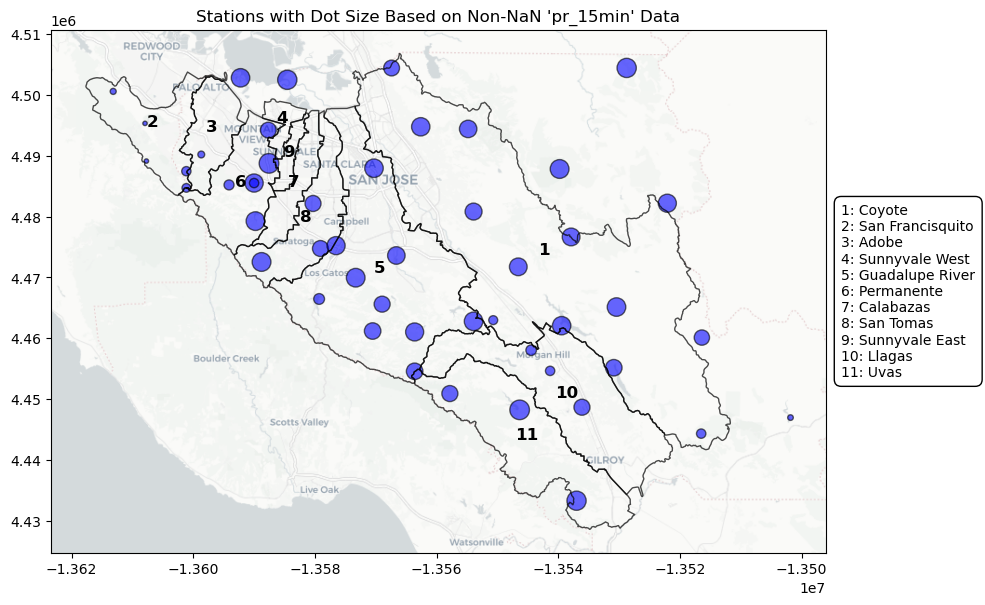

In [28]:
# Create a new DataFrame to store station data with non-NaN counts
station_data_list = []

for zarr_path, df in merged_datasets.items():
    # Count non-NaN values in 'pr_15min' for each station
    non_nan_counts = df.groupby('station')['pr_15min'].count().reset_index()
    non_nan_counts.rename(columns={'pr_15min': 'valid_pr_15min_count'}, inplace=True)

    # Merge with station geometries
    station_data = valley_water_stations[['station', 'geometry']].merge(non_nan_counts, on='station', how='left')

    station_data_list.append(station_data)

# Ensure we have valid station data before concatenation
if station_data_list:
    all_stations_df = pd.concat(station_data_list, ignore_index=True)
else:
    raise ValueError("No valid station data to concatenate!")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(all_stations_df, geometry='geometry', crs="EPSG:3857")

# Normalize size for visualization
gdf['size'] = gdf['valid_pr_15min_count'] / gdf['valid_pr_15min_count'].max() * 200  # Adjust scaling factor

# ---- FIXED WATERSHED LABELING ----
# Ensure watershed geometries are valid before calculating centroids
santa_clara_watersheds = santa_clara_watersheds.dropna(subset=['geometry'])
santa_clara_watersheds['geometry'] = santa_clara_watersheds.geometry.buffer(0)

# Assign numeric labels to watersheds
santa_clara_watersheds['watershed_id'] = range(1, len(santa_clara_watersheds) + 1)

# Compute watershed centroids
santa_clara_watersheds['centroid'] = santa_clara_watersheds.geometry.centroid

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot stations with size-based markers
gdf.plot(ax=ax, markersize=gdf['size'], alpha=0.6, color='blue', edgecolor='black', label="Stations")

# Plot watersheds with boundaries
santa_clara_watersheds.plot(ax=ax, color='none', edgecolor='black', linewidth=1, alpha=0.7)

# Label watersheds with numeric IDs at centroid
for _, row in santa_clara_watersheds.iterrows():
    plt.text(row['centroid'].x, row['centroid'].y, str(row['watershed_id']), 
             fontsize=12, ha='center', color='black', weight='bold')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

# Create legend for watershed numbers
watershed_legend = "\n".join([f"{row['watershed_id']}: {row['NAME']}" for _, row in santa_clara_watersheds.iterrows()])
plt.annotate(watershed_legend, xy=(1.02, 0.5), xycoords='axes fraction', ha='left', va='center', 
             fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Formatting
plt.title("Stations with Dot Size Based on Non-NaN 'pr_15min' Data")
plt.show()
